# The Wine Reviews Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import load_dataset,Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report,f1_score

## Introduction
The rimary objective is to fine-tune a pre-trained LLM for binary classification on a dataset consisting of wine reviews. The dataset contains two attributes: **description** and **points**. The description is a brief text describing the wine and the points represent a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is exceptional based on its review.

## 

## Exploring the Wine Reviews Dataset

*Note: The dataset is complete, with no missing values in any of its entries.*

In [2]:
dataset = load_dataset("csv",data_files="data/wine-reviews.csv")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['description', 'points'],
        num_rows: 10000
    })
})

In [3]:
df = dataset["train"].to_pandas()
df

,description,points
0,"Translucent in color, silky in the mouth, this...",85
1,"On the palate, this wine is rich and complex, ...",92
2,The producer blends 57% Chardonnay from the Ma...,92
3,"Pure Baga in all its glory, packed with dry an...",93
4,Think of Subsídio as a contribution rather tha...,89
...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92
9996,"An easy, versatile food wine or cocktail sippe...",84
9997,Black-fruit aromas blend nicely into chocolate...,93
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90


<Axes: ylabel='Frequency'>

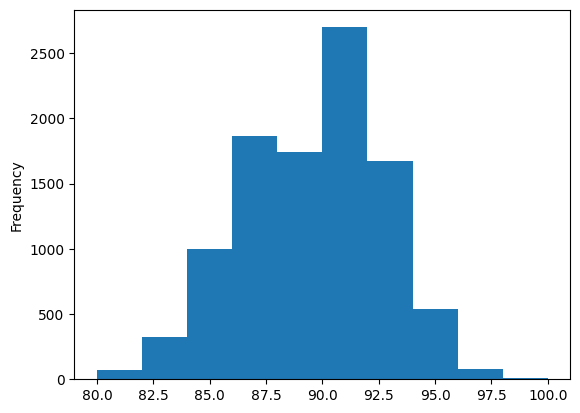

In [4]:
df['points'].plot.hist()

In [6]:
def exceptional_col(num):
    return 1 if num>=90 else 0

In [7]:
df['label'] = df['points'].apply(exceptional_col)
df

,description,points,label
0,"Translucent in color, silky in the mouth, this...",85,0
1,"On the palate, this wine is rich and complex, ...",92,1
2,The producer blends 57% Chardonnay from the Ma...,92,1
3,"Pure Baga in all its glory, packed with dry an...",93,1
4,Think of Subsídio as a contribution rather tha...,89,0
...,...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92,1
9996,"An easy, versatile food wine or cocktail sippe...",84,0
9997,Black-fruit aromas blend nicely into chocolate...,93,1
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90,1


In [8]:
df = df.drop(['points'], axis=1)

In [9]:
dataset["train"] = Dataset.from_pandas(df)

In [10]:
training_df,test_df = dataset['train'].train_test_split(test_size=0.2).values()

In [11]:
training_df

Dataset({
    features: ['description', 'label'],
    num_rows: 8000
})

In [12]:
test_df

Dataset({
    features: ['description', 'label'],
    num_rows: 2000
})

In [13]:
dataset['train'] = training_df

In [14]:
dataset['test'] = test_df

In [15]:
training_df,validation_df = dataset['train'].train_test_split(test_size=0.1).values()

In [16]:
dataset['train'] = training_df

In [17]:
dataset['val'] = validation_df

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['description', 'label'],
        num_rows: 7200
    })
    test: Dataset({
        features: ['description', 'label'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['description', 'label'],
        num_rows: 800
    })
})

In [19]:
token = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
dataset = dataset.map(lambda x: token(x['description'],truncation=True,padding=True,max_length=20),batched=True)

Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [20]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased",num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
args = TrainingArguments(
    output_dir="wine",
    eval_strategy= "epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    metric_for_best_model="f1"
)

In [22]:
def compute_metrics(eval_pred):
    logits,labels = eval_pred
    pred = np.argmax(logits,axis=-1)
    f1 = f1_score(labels, pred, average='weighted')
    return {"f1": f1}

In [23]:
trainer = Trainer(
    model=model,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val']
)

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.651500,0.583236,0.695000
2,0.503000,0.646790,0.690971
3,0.355100,0.790278,0.701337


TrainOutput(global_step=2700, training_loss=0.48982373272931135, metrics={'train_runtime': 1972.1363, 'train_samples_per_second': 10.953, 'train_steps_per_second': 1.369, 'total_flos': 221999952960000.0, 'train_loss': 0.48982373272931135, 'epoch': 3.0})

In [25]:
preds = trainer.predict(dataset['test'])

In [26]:
preds = np.argmax(preds.predictions,axis=-1)

In [27]:
print(classification_report(dataset['test']['label'],preds))

              precision    recall  f1-score   support

           0       0.71      0.68      0.70      1013
           1       0.69      0.72      0.70       987

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000

